<a href="https://colab.research.google.com/github/ewclark47/ADL-Project/blob/main/seq2seq_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install "tensorflow-text>=2.11"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np

import typing 
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf 
import tensorflow_text as tf_text 

#### Download the data

In [9]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True 
)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [10]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines] # tab deliminated so split by tab
  
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [11]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [12]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


#### Create a tensorflow dataset from the data

In [13]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 

train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

In [14]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Si fuera cierto, \xc2\xbfqu\xc3\xa9 har\xc3\xada usted?'
 b'Me gustar\xc3\xada tomar un vaso de vino.'
 b'No puedo creer que te agrade ese restaurante.'
 b'Le pregunt\xc3\xa9 cu\xc3\xa1l era su nombre.'
 b'Juguemos tenis despu\xc3\xa9s de clases.'], shape=(5,), dtype=string)

tf.Tensor(
[b'If that were true, what would you do?'
 b"I'd like to have a glass of wine."
 b"I can't believe that you like that restaurant."
 b'I asked him what his name was.' b"Let's play tennis after school."], shape=(5,), dtype=string)


#### Text standardization and preprocessing

##### example

In [15]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [16]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [17]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [18]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [19]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [20]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [21]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 45, 195, 458, 19, 13, 5, 704, 132, 12, 3],
 [2, 18, 168, 328, 16, 831, 6, 231, 4, 3],
 [2, 9, 55, 411, 5, 30, 1, 97, 663, 4, 3]]>

In [22]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] si fuera cierto , ¿ que haria usted ? [END]'

Text(0.5, 1.0, 'Mask')

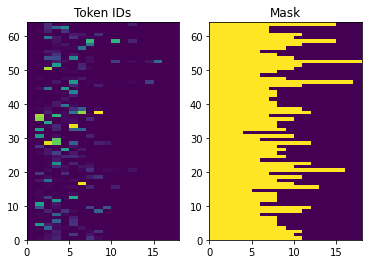

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

#### Process the dataset